# SPY Index compared to indiv stocks

Investigate the relationship between the price fluctuations of the S&P 500 and its constituents.

In [1]:
import os
from dotenv import load_dotenv
from datetime import date, datetime
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

from alpaca.data import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame

from scraper import get_spy_tickers

load_dotenv();

api_key = os.getenv('PAPER_API_KEY')
api_secret = os.getenv('PAPER_API_SECRET')
client = StockHistoricalDataClient(api_key, api_secret)



#### Data getters

In [2]:
def get_historical_data(symbol, start_date, end_date, timeframe):
    """Retrieves historical stock data for a given symbol and date range.

    Args:
        symbol (str): The stock symbol (e.g., "AAPL").
        start_date (datetime): The start date for the historical data (inclusive).
        end_date (datetime): The end date for the historical data (inclusive).
        timeframe (TimeFrame): The timeframe for the historical data (e.g., TimeFrame.Day, TimeFrame.Hour).

    Returns:
        pandas.DataFrame: The DataFrame containing the historical stock data.
    """

    params = StockBarsRequest(
        symbol_or_symbols=symbol,
        timeframe=timeframe,
        start=start_date,
        end=end_date
    )

    bars = client.get_stock_bars(params)
    df = bars.df
    
    # Calculate the percentage change
    df['percent_change'] = (df['close'] - df['open']) / df['open'] * 100

    return df

#### Plotting

Simply plotting for exploring stock prices and changes

In [3]:
def plot_candlestick(df, title_suffix=""):
    """Plots a candlestick chart from a DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the stock data.
        title_suffix (str, optional): A suffix to add to the plot title (default: "").
    """

    symbol = df.index.get_level_values('symbol')[0]
    start_date = df.index.get_level_values('timestamp')[0].strftime('%Y-%m-%d')
    end_date = df.index.get_level_values('timestamp')[-1].strftime('%Y-%m-%d')

    title = f"{symbol} Candlestick Chart ({start_date} - {end_date}) {title_suffix}"

    # Ensure the DataFrame is in the correct format for mplfinance
    df = df.reset_index()
    df.set_index('timestamp', inplace=True)

    mpf.plot(df, type='candle', style='charles', title=title, ylabel='Price (USD)', volume=True)


def plot_percentage_change(df, title_suffix=""):
    """Plots the open/close percentage change from a DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the stock data.
        title_suffix (str, optional): A suffix to add to the plot title (default: "").
    """

    plt.figure(figsize=(10, 6))
    plt.plot(df.index.get_level_values('timestamp'), df['percent_change'], label='Open/Close % Change')
    plt.xlabel('Date')
    plt.ylabel('Percentage Change (%)')

    # Extract symbol and date range from dataframe index
    symbol = df.index.get_level_values('symbol')[0]
    start_date = df.index.get_level_values('timestamp')[0].strftime('%Y-%m-%d')
    end_date = df.index.get_level_values('timestamp')[-1].strftime('%Y-%m-%d')

    title = f"{symbol} Open/Close % Change ({start_date} - {end_date}) {title_suffix}"
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

# symbol = "SPY"
# start_date = datetime(2024, 6, 1)
# end_date = datetime(2024, 6, 7)
# timeframe = TimeFrame.Hour

# df = get_historical_data(symbol, start_date, end_date, timeframe)
# plot_candlestick(df)
# plot_percentage_change(df)

# symbol = "AMZN"
# start_date = datetime(2024, 6, 3)
# end_date = datetime(2024, 6, 4)
# timeframe = TimeFrame.Minute

# print(len(df))
# df = get_historical_data(symbol, start_date, end_date, timeframe)
# plot_candlestick(df)
# plot_percentage_change(df)

#### Correlation

Calculate the correlation of stock price. Specifically, the price between the SPY index and the constituents thereof.

The correlation is based on the percentage difference of price changes per stock to normalise the data.

In [4]:
def calculate_correlations(etf_df, stock_dfs):
    """Calculates the Pearson correlation between SPY and each stock's percentage change.

    Args:
        etf_df (pandas.DataFrame): The DataFrame containing the ETF data.
        stock_dfs (dict): A dictionary where keys are stock symbols and values are their DataFrames.

    Returns:
        dict: A dictionary where keys are stock symbols and values are their correlation with ETF.
    """
    correlations = {}

    # Make 'timestamp' a column
    etf_df = etf_df.reset_index()
    etf_df = etf_df[['timestamp', 'percent_change']].set_index('timestamp')

    for symbol, df in stock_dfs.items():
        # Make 'timestamp' a column
        if not df.empty:
            df = df.reset_index()
            df = df[['timestamp', 'percent_change']].set_index('timestamp')
            
            # Align the data on the 'timestamp' index
            aligned_df = etf_df.join(df, how='inner', lsuffix='_etf', rsuffix=f'_{symbol}')
            
            if len(aligned_df) > 1:
                pearson_corr, _ = pearsonr(aligned_df['percent_change_etf'], aligned_df[f'percent_change_{symbol}'])
                spearman_corr, _ = spearmanr(aligned_df['percent_change_etf'], aligned_df[f'percent_change_{symbol}'])
                correlations[symbol] = (pearson_corr, spearman_corr)

    return correlations

In [5]:
def calculate_correlations(spy_df, stock_dfs):
    """Calculates the Pearson and Spearman correlation between SPY and each stock's percentage change.

    Args:
        spy_df (pandas.DataFrame): The DataFrame containing the SPY data.
        stock_dfs (dict): A dictionary where keys are stock symbols and values are their DataFrames.

    Returns:
        dict: A dictionary where keys are stock symbols and values are tuples of (Pearson correlation, Spearman correlation) with SPY.
    """
    correlations = {}

    # Make 'timestamp' a column
    spy_df = spy_df.reset_index()
    spy_df = spy_df[['timestamp', 'percent_change']].set_index('timestamp')

    for symbol, df in stock_dfs.items():
        if not df.empty:
            # Make 'timestamp' a column
            df = df.reset_index()
            df = df[['timestamp', 'percent_change']].set_index('timestamp')
            
            # Align the data on the 'timestamp' index
            aligned_df = spy_df.join(df, how='inner', lsuffix='_spy', rsuffix=f'_{symbol}')
            
            if len(aligned_df) > 1:
                pearson_corr, _ = pearsonr(aligned_df['percent_change_spy'], aligned_df[f'percent_change_{symbol}'])
                spearman_corr, _ = spearmanr(aligned_df['percent_change_spy'], aligned_df[f'percent_change_{symbol}'])
                correlations[symbol] = (pearson_corr, spearman_corr)
            print('Finished corr. of ', symbol)

    return correlations


def calculate_correlations(spy_df, stock_dfs):
    """Calculates the Pearson and Spearman correlation between SPY and each stock's percentage change.

    Args:
        spy_df (pandas.DataFrame): The DataFrame containing the SPY data.
        stock_dfs (dict): A dictionary where keys are stock symbols and values are their DataFrames.

    Returns:
        dict: A dictionary where keys are stock symbols and values are tuples of (Pearson correlation, Spearman correlation) with SPY.
    """
    correlations = {}

    # Make 'timestamp' a column
    spy_df = spy_df.reset_index()
    spy_df = spy_df[['timestamp', 'percent_change']].set_index('timestamp')

    for symbol, df in stock_dfs.items():
        if not df.empty:
            # Make 'timestamp' a column
            df = df.reset_index()
            df = df[['timestamp', 'percent_change']].set_index('timestamp')
            
            # Align the data on the 'timestamp' index
            aligned_df = spy_df.join(df, how='inner', lsuffix='_spy', rsuffix=f'_{symbol}')
            
            if len(aligned_df) > 1:
                pearson_corr, _ = pearsonr(aligned_df['percent_change_spy'], aligned_df[f'percent_change_{symbol}'])
                spearman_corr, _ = spearmanr(aligned_df['percent_change_spy'], aligned_df[f'percent_change_{symbol}'])
                correlations[symbol] = (pearson_corr, spearman_corr)

    return correlations


In [6]:
time_periods = [
    ("2024-05-13", "2024-05-18"),
    ("2024-05-20", "2024-05-25"),
    ("2024-05-27", "2024-06-01")
]

constituents = get_spy_tickers()
# constituents = ["AAPL", "META", "AMZN"]

results = {symbol: [] for symbol in constituents}

# Loop through each time period and calculate correlations
for start_str, end_str in time_periods:
    start_date = datetime.strptime(start_str, '%Y-%m-%d')
    end_date = datetime.strptime(end_str, '%Y-%m-%d')
    timeframe = TimeFrame.Hour

    spy_df = get_historical_data("SPY", start_date, end_date, timeframe)

    stock_dfs = {}
    for symbol in constituents:
        stock_dfs[symbol] = get_historical_data(symbol, start_date, end_date, timeframe)

    correlations = calculate_correlations(spy_df, stock_dfs)

    for symbol, (pearson_corr, spearman_corr) in correlations.items():
        results[symbol].append((pearson_corr, spearman_corr))

    print(f"Finished time period {start_str} to {end_str}")


# Print the results
print("\n\nSymbol: Pearson and Spearman correlations for each time period\n")
for symbol, correlations in results.items():
    correlations_str = " ".join([f"({p:.2f}, {s:.2f})" for p, s in correlations])
    print(f"{symbol}: {correlations_str}")

Finished time period 2024-05-13 to 2024-05-18
Finished time period 2024-05-20 to 2024-05-25
Finished time period 2024-05-27 to 2024-06-01


Symbol: Pearson and Spearman correlations for each time period

MMM: (0.21, 0.27) (0.42, 0.29) (0.28, 0.22)
AOS: (0.26, 0.35) (0.72, 0.61) (0.47, 0.16)
ABT: (0.13, 0.14) (0.28, 0.02) (0.33, 0.31)
ABBV: (0.07, 0.05) (-0.16, -0.15) (0.38, 0.14)
ACN: (0.35, 0.43) (0.47, 0.35) (0.55, 0.36)
ADBE: (0.24, 0.17) (0.35, 0.37) (0.66, 0.39)
AMD: (0.50, 0.43) (0.68, 0.57) (0.61, 0.55)
AES: (0.20, 0.13) (0.41, 0.32) (0.29, 0.22)
AFL: (0.16, 0.11) (0.29, 0.32) (0.48, 0.27)
A: (0.41, 0.52) (0.49, 0.52) (0.13, -0.09)
APD: (0.21, 0.25) (0.25, 0.21) (0.59, 0.24)
ABNB: (0.14, 0.04) (0.39, 0.31) (0.54, 0.45)
AKAM: (0.05, 0.06) (0.41, 0.37) (0.09, -0.22)
ALB: (0.28, 0.20) (0.33, 0.39) (0.47, 0.50)
ARE: (0.40, 0.31) (0.80, 0.70) (0.38, 0.09)
ALGN: (0.32, 0.39) (0.58, 0.34) (0.51, 0.46)
ALLE: (0.35, 0.36) (0.66, 0.46) (0.47, 0.36)
LNT: (0.51, 0.31) (0.25, 0.01) (0.19, -0

#### Visualise the results

A line graph of the correlations is shown over the different time periods. A random sample of the 503 tickers in the S&P 500 is chosen for clarit.

Thereafter, a heatmap showing the full results is shown

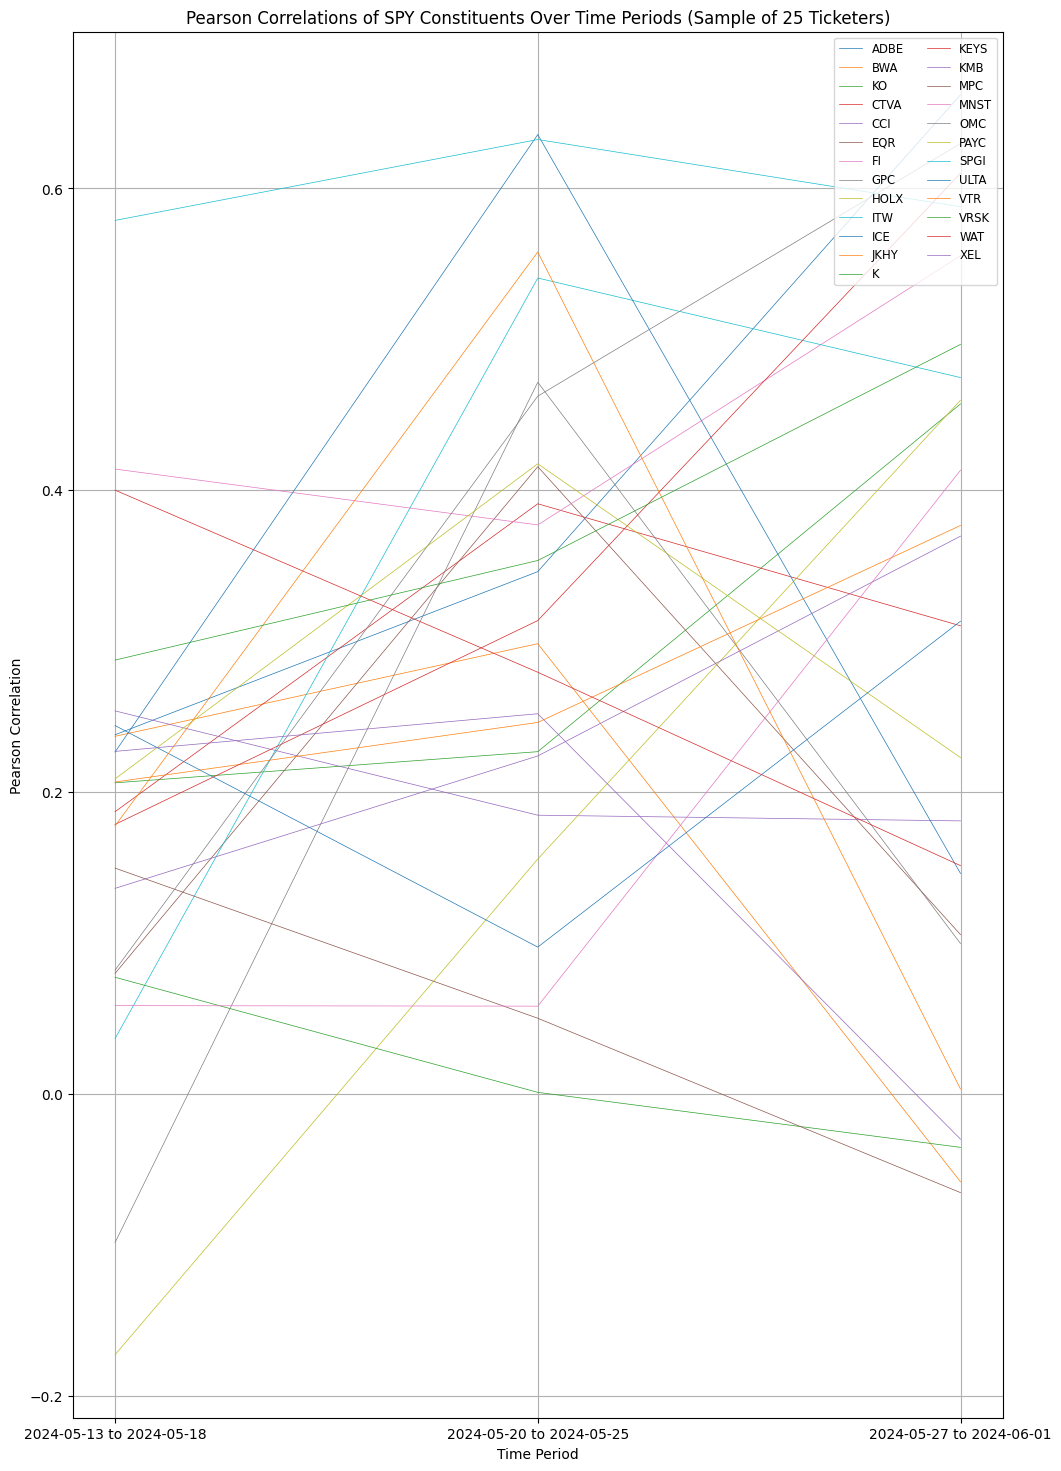

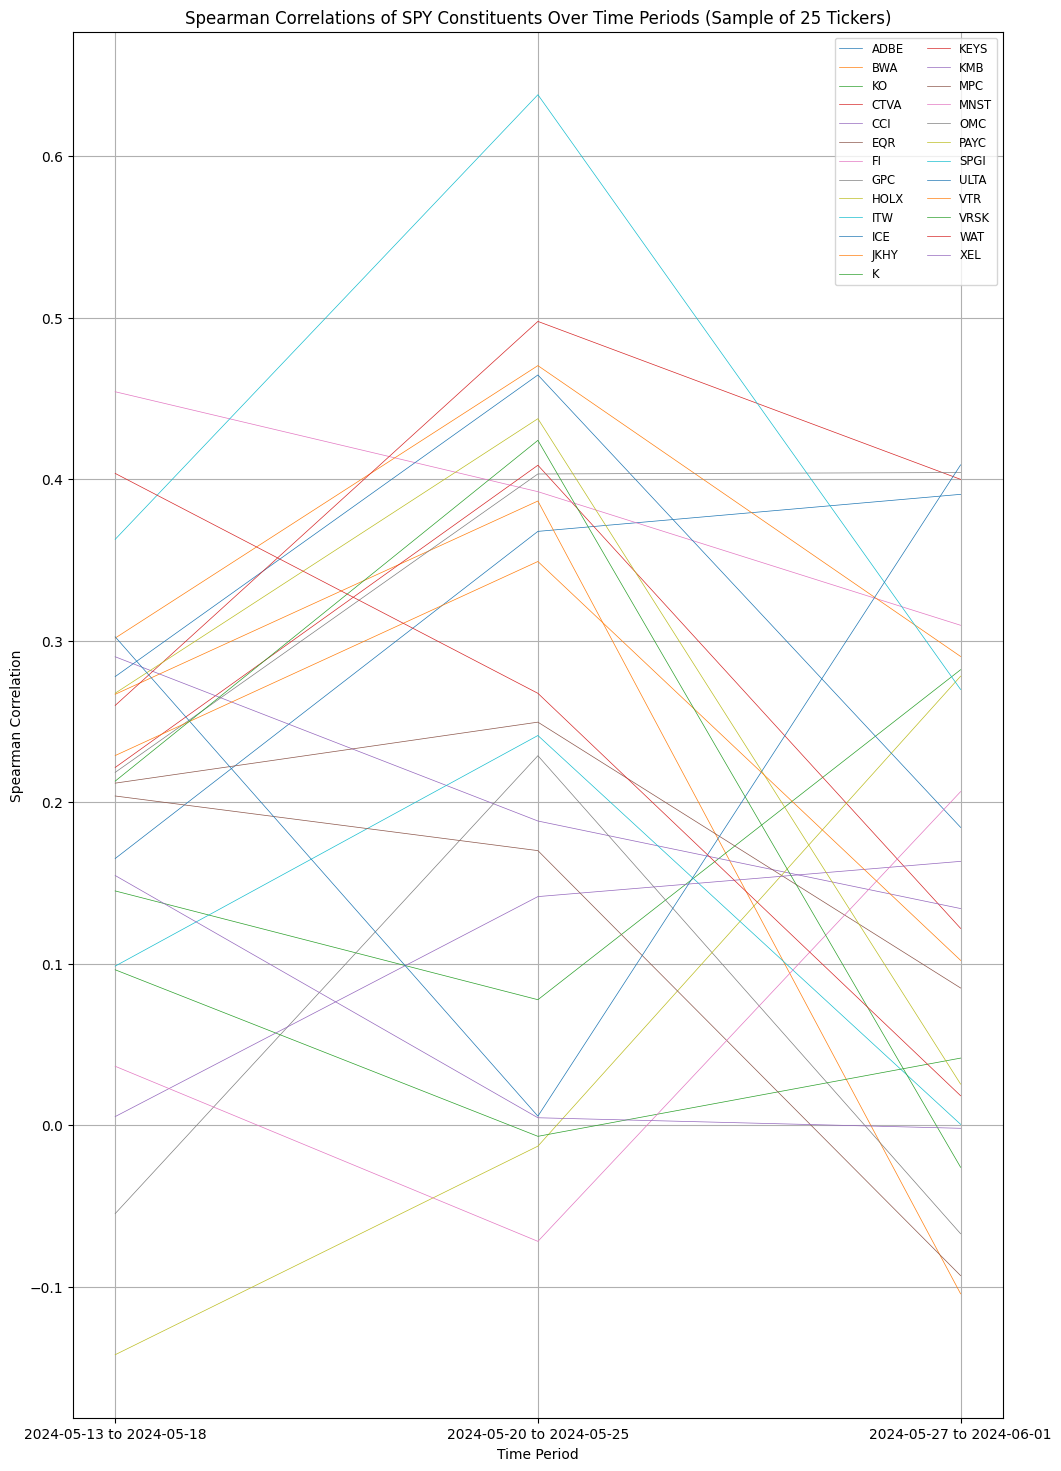

In [8]:
symbols = list(results.keys())

# Define the time period labels for the x-axis
time_period_labels = ["2024-05-13 to 2024-05-18", "2024-05-20 to 2024-05-25", "2024-05-27 to 2024-06-01"]

# Select a random sample for clarity
random_symbols = random.sample(symbols, 25)

# Prepare the data for plotting
pearson_sample_data = {symbol: [correlations[i][0] for i in range(len(time_period_labels))] for symbol, correlations in results.items() if symbol in random_symbols}
spearman_sample_data = {symbol: [correlations[i][1] for i in range(len(time_period_labels))] for symbol, correlations in results.items() if symbol in random_symbols}

# Plot Pearson correlations
plt.figure(figsize=(12, 18))  # Make the figure long vertically
for symbol, correlations in pearson_sample_data.items():
    plt.plot(time_period_labels, correlations, label=symbol, linewidth=0.5)  # Thin lines

plt.xlabel("Time Period")
plt.ylabel("Pearson Correlation")
plt.title("Pearson Correlations of SPY Constituents Over Time Periods (Sample of 25 Ticketers)")
plt.grid(True)
plt.legend(loc='upper right', fontsize='small', ncol=2)  # Adjust legend to prevent overlap
plt.show()

# Plot Spearman correlations
plt.figure(figsize=(12, 18))  # Make the figure long vertically
for symbol, correlations in spearman_sample_data.items():
    plt.plot(time_period_labels, correlations, label=symbol, linewidth=0.5)  # Thin lines

plt.xlabel("Time Period")
plt.ylabel("Spearman Correlation")
plt.title("Spearman Correlations of SPY Constituents Over Time Periods (Sample of 25 Tickers)")
plt.grid(True)
plt.legend(loc='upper right', fontsize='small', ncol=2)  # Adjust legend to prevent overlap
plt.show()

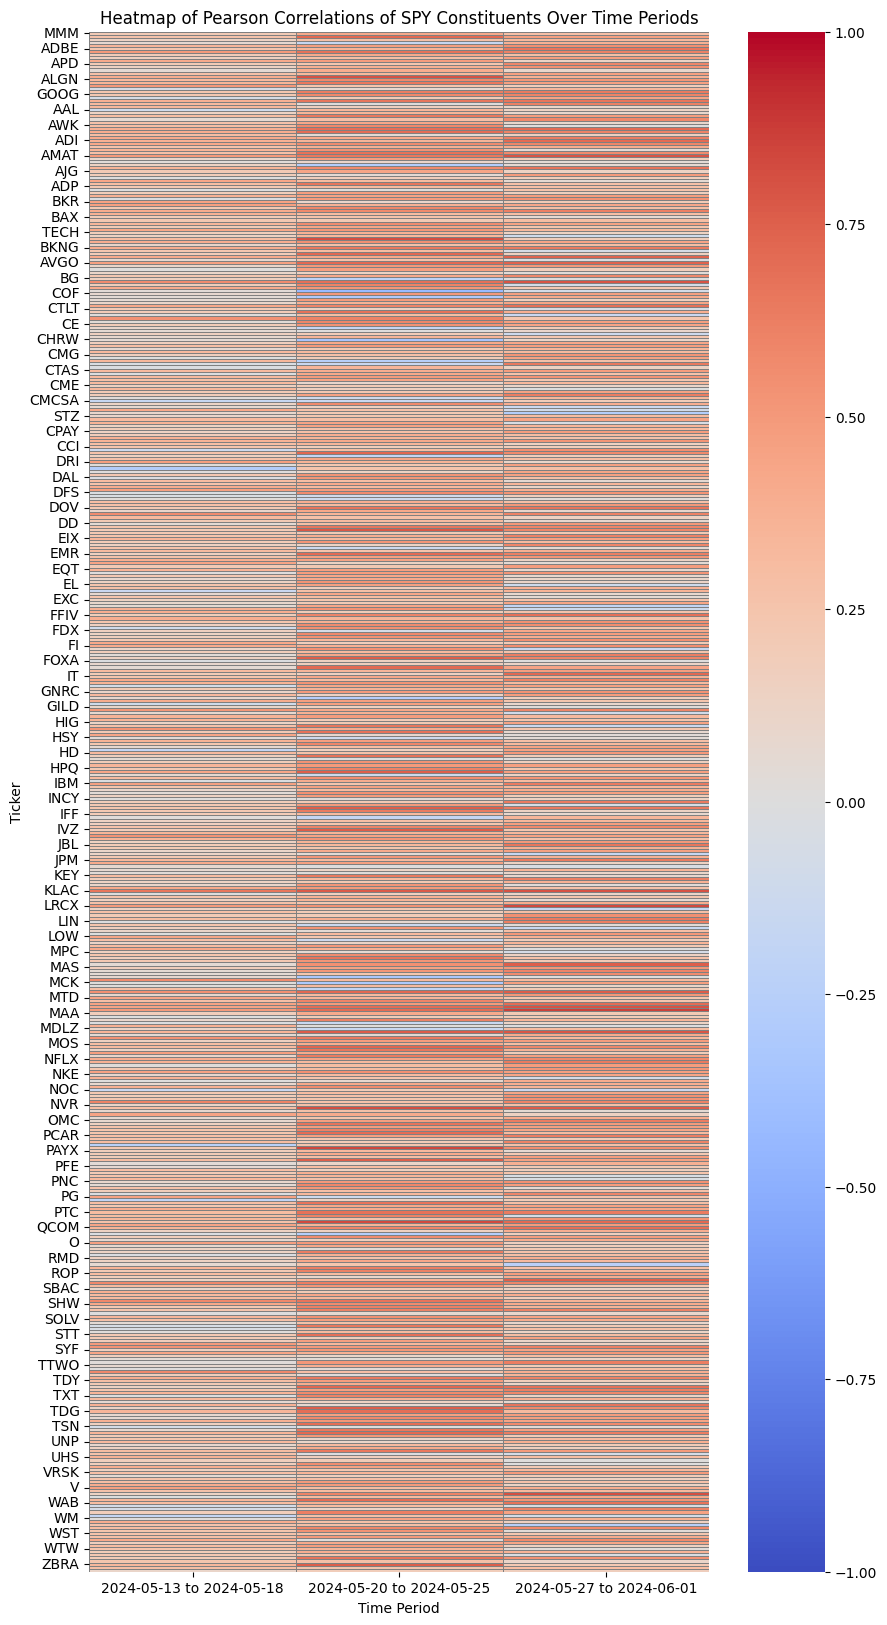

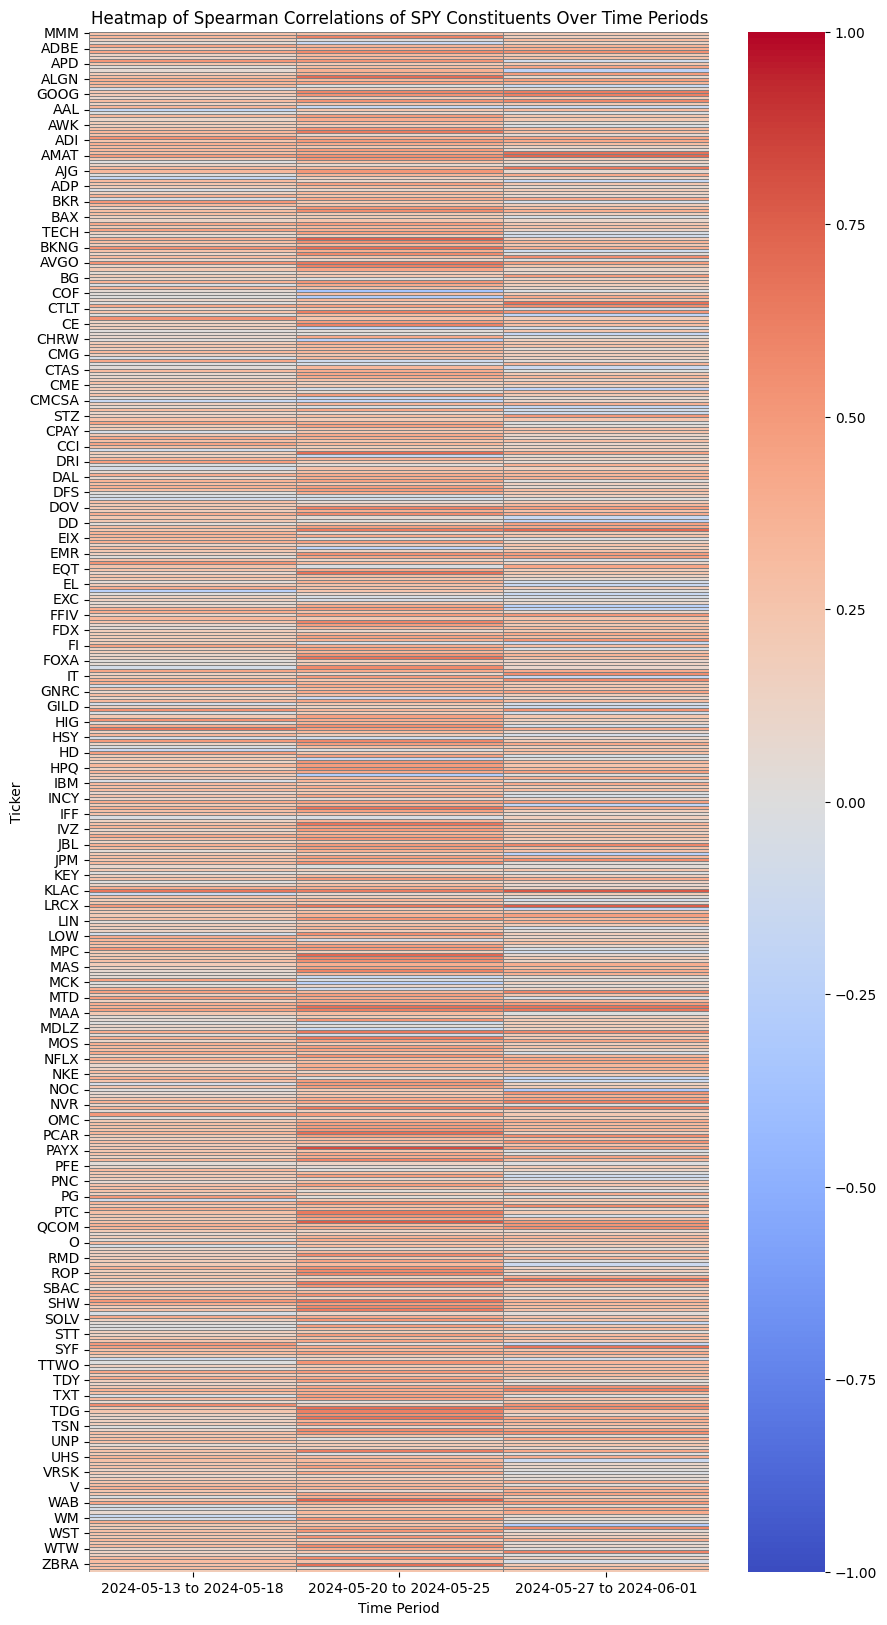

In [9]:
# Prepare data for heatmap
pearson_data = np.array([[correlations[i][0] for i in range(len(time_period_labels))] for correlations in results.values()])
spearman_data = np.array([[correlations[i][1] for i in range(len(time_period_labels))] for correlations in results.values()])

# Create a DataFrame for the Pearson correlations
pearson_df = pd.DataFrame(pearson_data, index=symbols, columns=time_period_labels)

# Create a DataFrame for the Spearman correlations
spearman_df = pd.DataFrame(spearman_data, index=symbols, columns=time_period_labels)

# Plot Pearson heatmap
plt.figure(figsize=(10, 20))
sns.heatmap(pearson_df, cmap="coolwarm", linewidths=0.5, linecolor='gray', vmin=-1, vmax=1)
plt.title("Heatmap of Pearson Correlations of SPY Constituents Over Time Periods")
plt.xlabel("Time Period")
plt.ylabel("Ticker")
plt.show()

# Plot Spearman heatmap
plt.figure(figsize=(10, 20))
sns.heatmap(spearman_df, cmap="coolwarm", linewidths=0.5, linecolor='gray', vmin=-1, vmax=1)
plt.title("Heatmap of Spearman Correlations of SPY Constituents Over Time Periods")
plt.xlabel("Time Period")
plt.ylabel("Ticker")
plt.show()

#### Conclusion

In [23]:
print("\n\nAverage Pearson and Spearman correlations for each time period\n")
print("\n Time period\t\t\t Pearson correlation\t\t Spearman correlation")

total_pearson_all = 0
total_spearman_all = 0
count_all = 0

for i, (start_str, end_str) in enumerate(time_periods):
    total_pearson = 0
    total_spearman = 0
    count = 0
    for symbol in results:
        if len(results[symbol]) > i:
            total_pearson += results[symbol][i][0]
            total_spearman += results[symbol][i][1]
            count += 1
    avg_pearson = total_pearson / count
    avg_spearman = total_spearman / count
    print(f"{start_str} to {end_str}\t {avg_pearson:.2f} \t\t\t\t {avg_spearman:.2f}")
    
    # Accumulate totals for all periods
    total_pearson_all += total_pearson
    total_spearman_all += total_spearman
    count_all += count

# Calculate overall averages
overall_avg_pearson = total_pearson_all / count_all
overall_avg_spearman = total_spearman_all / count_all
print(f"Entire period \t\t\t {overall_avg_pearson:.2f} \t\t\t\t {overall_avg_spearman:.2f}")




Average Pearson and Spearman correlations for each time period


 Time period			 Pearson correlation		 Spearman correlation
2024-05-13 to 2024-05-18	 0.22 				 0.21
2024-05-20 to 2024-05-25	 0.37 				 0.32
2024-05-27 to 2024-06-01	 0.33 				 0.21
Entire period 			 0.30 				 0.25


The results show that
* A correlation between SPY price fluctuations and the fluncuations of individual constituents is present over all tested time periods.
* The correlation is weakly positive, regardless of which correlation coefficient is used. Strong correlations, up to 0.8 are present in certain stocks and time periods.
* A correlation in one time period does not indicate anything about the correlation in the subsequent time period.
* **A decision to trade/how to trade a stock should not be influenced by the current performance of its ETF. The correlation can be justified by that stock being a constituent, as well as a large company that maintains a stable price.**

Not that the testing was conducted with hourly price fluctuations. The result is expected, though untested, to hold for fluctuations per minute and per day. A stronger correlation could more possibly be present in longer timeframes.

Further testing could include other ETF, different time periods, and a larger sample of time periods.
Additionally, better season correlation indicators do exist. Could look into the Dikcer-Fuller test